This notebook corresponds to the development of Script chapter 3.4.1. from the main text of the dissertation titled: Nobel Microorganisms Associated with Corrosion by this Author

## Preprocessing I
### Script to narrow down the most important bacteria following criteria chapter 3.3 main text

1. Identify the most relevant bacteria genus amongts the 880 genus by filering out the percentage that is in a concentration of less than 2%
 
2. Additionally it sorted those left by the occurence in the totality of each traffic light category, by making a column named influence and order them for influence frequency.

3. Perform an statistical analysis using non parametric test give us a list of the GIDs to use on each TL category.

 *Influencers:  Script to narrow down the most important bacteria.*
 
 >### Filtering and sorting

In [1]:
# Import the pandas library for data manipulation
import pandas as pd
import os
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
# Read the excel file coming from notebook Splitdf.ipynb
abundance_1 = pd.read_csv('data/abundance_1.csv', dtype={i: float for i in range(8, 71)})
abundance_2 = pd.read_csv('data/abundance_2.csv', dtype={i: float for i in range(8, 71)})
abundance_3 = pd.read_csv('data/abundance_3.csv', dtype={i: float for i in range(8, 71)})

taxonomic_columns_1 = pd.read_csv('data/taxonomic_columns_1.csv')
taxonomic_columns_2 = pd.read_csv('data/taxonomic_columns_2.csv')
taxonomic_columns_3 = pd.read_csv('data/taxonomic_columns_3.csv')

In [3]:
print(abundance_1.shape, abundance_2.shape, abundance_3.shape)

(882, 18) (882, 33) (882, 22)


In [4]:
abundance_1.head()

,GID,site_2,site_3,site_4,site_5,site_17,site_18,site_21,site_24,site_26,site_28,site_35,site_57,site_58,site_59,site_60,site_69,site_70
0,1,0.0,0.0,0.0000,0.0000,0.0,0.0,0.0000,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0018,0.0,0.0
1,2,0.0,0.0,0.0000,0.0000,0.0,0.0,0.0000,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0000,0.0,0.0
2,3,0.0,0.0,0.0154,0.0037,0.0,0.0,0.0000,0.0,0.0,0.0,0.0362,0.0,0.0,0.0,0.0000,0.0,0.0
3,4,0.0,0.0,0.0000,0.0000,0.0,0.0,0.0016,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0000,0.0,0.0
4,5,0.0,0.0,0.0000,0.0000,0.0,0.0,0.0000,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0000,0.0,0.0


In [5]:
# Making sure the column GID is taken as an integer type
abundance_1["GID"] = abundance_1["GID"].astype("int")
abundance_2["GID"] = abundance_2["GID"].astype("int")
abundance_3["GID"] = abundance_3["GID"].astype("int")

In [6]:
abundance_1["GID"].dtypes

dtype('int64')

In [7]:
def filter_values_by_threshold(abundance, threshold_percentage):
    """
    Filter the columns of a DataFrame based on a given threshold percentage.

    Parameters:
    data_excluded (pd.DataFrame): The input DataFrame to be filtered.
    threshold_percentage (float): The threshold percentage used to filter the data.

    Returns:
    pd.DataFrame: A DataFrame containing the filtered values for each sample based on the provided threshold percentage.
    """

    # Create an empty DataFrame with the same columns as the original DataFrame, which only contain the abundance data without the 6 taxa levels
    filtered_data_combined = pd.DataFrame(columns=abundance.columns)

    # Loop through each column (sample) in data, excluding the 'GID' column
    for column in abundance.columns[1:]:
        # Calculate the threshold value for the current column based on the percentage
        threshold = abundance[column].sum() * (threshold_percentage / 100)

        # Filter the rows in the current column where the value is greater than or equal to the threshold
        filtered_data = abundance[abundance[column] >= threshold]

        # Append the filtered_data to the filtered_data_combined DataFrame
        filtered_data_combined = filtered_data_combined.append(filtered_data, ignore_index=True)

    # Drop duplicates in the 'GID' column and reset the index
    filtered_data_combined = filtered_data_combined.drop_duplicates(subset='GID', keep='first').reset_index(drop=True)

    return filtered_data_combined

In [8]:
def get_frequency_GID(filtered_data_combined):
    """
    Count the occurrences of each GID in the samples and merge the influence counts with the original DataFrame.

    Parameters:
    filtered_data_combined (pd.DataFrame): The input DataFrame with filtered data.

    Returns:
    pd.DataFrame: A DataFrame with the added 'Influence' column, sorted by 'Influence' in descending order.
    """

    # Initialize an empty dictionary to store the GID counts
    gid_counts = {}

    # Loop through each column (sample) in filtered_data_combined, excluding the 'GID' column
    for column in filtered_data_combined.columns[1:]:
        # Count the occurrences of each GID in the current column and update the gid_counts dictionary
        for index, row in filtered_data_combined.iterrows():
            if row[column] != 0:
                gid = row['GID']
                gid_counts[gid] = gid_counts.get(gid, 0) + 1

    # Create a DataFrame with the 'GID' and 'Influence' columns from the gid_counts dictionary
    influence_df = pd.DataFrame(list(gid_counts.items()), columns=['GID', 'Influence'])

    # Merge the influence_df DataFrame with the filtered_data_combined DataFrame on the 'GID' column
    influencers_genus = filtered_data_combined.merge(influence_df, on='GID')

    # Sort the influence_genera DataFrame by the 'Influence' column in descending order
    influencers_genus = influencers_genus.sort_values(by='Influence', ascending=False).reset_index(drop=True)

    return influencers_genus

In [9]:
def merge_taxonomic_columns_and_influencers_genus(taxonomic_columns, influencers_genus):
    """
    Merge original taxonomic columns with influence genera, sort by Influence, and save the resultant DataFrame to a CSV file.

    Parameters:
    taxonomic_columns (pd.DataFrame): The DataFrame containing the taxonomic columns.
    influencers_genera (pd.DataFrame): The DataFrame containing the influencers' genera information.
    """

    # Merge the DataFrames based on the 'GID' column
    Influencers = pd.merge(taxonomic_columns, influencers_genus, on='GID', how='inner')
    
    # Sort the merged DataFrame by the 'Influence' column in descending order
    Influencers = Influencers.sort_values('Influence', ascending=False).reset_index(drop=True)
    
    return Influencers


In [10]:
# Filter values by threshold
threshold_percentage = 2

filtered_data_combined_1 = filter_values_by_threshold(abundance_1, threshold_percentage)
filtered_data_combined_2 = filter_values_by_threshold(abundance_2, threshold_percentage)
filtered_data_combined_3 = filter_values_by_threshold(abundance_3, threshold_percentage)

# Get the frequency of GID
influencers_genus_1 = get_frequency_GID(filtered_data_combined_1)
influencers_genus_2 = get_frequency_GID(filtered_data_combined_2)
influencers_genus_3 = get_frequency_GID(filtered_data_combined_3)

# Merge taxonomic columns and influence genera

Influencers_1 = merge_taxonomic_columns_and_influencers_genus(taxonomic_columns_1, influencers_genus_1)
Influencers_2 = merge_taxonomic_columns_and_influencers_genus(taxonomic_columns_2, influencers_genus_2)
Influencers_3 = merge_taxonomic_columns_and_influencers_genus(taxonomic_columns_2, influencers_genus_3)

In [11]:
Influencers_1.head()
print(Influencers_1.shape, Influencers_2.shape, Influencers_3.shape)

(77, 25) (92, 40) (85, 29)


In [12]:
Influencers_2.head()

,Kingdom,Phylum,Class,Order,Familia,Genera,GID,site_6,site_7,site_10,...,site_52,site_53,site_54,site_61,site_62,site_63,site_64,site_65,site_66,Influence
0,Bacteria,Proteobacteria,Alphaproteobacteria,Sphingomonadales,Sphingomonadaceae,Sphingomonas,674,3.60,0.3516,0.94,...,0.0960,0.4965,0.6908,0.4649,0.1177,0.2080,0.00,0.0544,0.00,29
1,Bacteria,Proteobacteria,Betaproteobacteria,Burkholderiales,Comamonadaceae,Acidovorax,17,8.84,1.9304,0.00,...,0.0072,0.0000,2.6088,0.7624,2.0323,1.9186,10.95,3.5384,12.14,28
2,Bacteria,Proteobacteria,Alphaproteobacteria,Rhizobiales,Bradyrhizobiaceae,Bradyrhizobium,143,0.00,3.3079,0.00,...,0.0004,0.0662,0.0286,0.5392,0.4187,0.4161,0.00,0.1633,0.00,28
3,Bacteria,Proteobacteria,Betaproteobacteria,Rhodocyclales,Rhodocyclaceae,Azospira,110,0.00,2.1462,0.00,...,0.0040,0.0000,2.3206,0.3533,0.5713,0.6241,0.26,4.5182,0.40,26
4,Bacteria,Actinobacteria,Actinobacteria,Actinomycetales,Propionibacteriaceae,Propionibacterium,572,0.00,4.9279,0.00,...,0.0000,0.0000,0.0802,0.2045,0.1526,0.2774,6.99,1.5242,0.00,25


In [13]:
Influencers_3.head()

,Kingdom,Phylum,Class,Order,Familia,Genera,GID,site_1,site_8,site_9,...,site_34,site_40,site_44,site_47,site_49,site_55,site_56,site_67,site_68,Influence
0,Bacteria,Proteobacteria,Betaproteobacteria,Burkholderiales,Comamonadaceae,Acidovorax,17,6.2473,0.00,2.5307,...,9.90,0.1695,1.66,0.1690,4.68,0.2774,0.1076,1.9934,0.0053,20
1,Bacteria,Proteobacteria,Alphaproteobacteria,Sphingomonadales,Sphingomonadaceae,Novosphingobium,491,0.0862,2.31,0.2233,...,57.39,0.0000,0.31,0.1869,1.10,3.3899,7.3419,1.3973,0.0212,20
2,Bacteria,Actinobacteria,Actinobacteria,Actinomycetales,Propionibacteriaceae,Propionibacterium,572,4.7824,0.00,5.4424,...,2.49,0.3319,0.00,6.8474,5.12,0.1099,6.6079,0.1075,0.0053,19
3,Bacteria,Proteobacteria,Betaproteobacteria,Rhodocyclales,Rhodocyclaceae,Azospira,110,26.9280,0.54,3.9032,...,0.00,0.0000,60.30,21.5485,4.74,8.2225,12.5593,0.0049,0.0000,18
4,Bacteria,Proteobacteria,Gammaproteobacteria,Pseudomonadales,Pseudomonadaceae,Pseudomonas,587,5.2779,0.00,2.8195,...,0.00,2.0621,1.66,0.2486,0.00,0.0140,0.9424,12.2728,20.8913,18


To get the statistics, we transpose the df first

In [14]:
Influencers_1_T1= Influencers_1.T 
# we discard the taxa levels and the influence column, because we interested just in the abundance for getting those statistics
Influencers_1_T= Influencers_1_T1.iloc[6:-1, :]

In [15]:
# Now, we extract the first row (GID values) and set it as the column names:
Influencers_1_T.columns = Influencers_1_T.iloc[0]
#Remove the first row (GID values) from the DataFrame, as they are now the column names:
Influencers_1_T = Influencers_1_T.drop(Influencers_1_T.index[0])
I_1_Stat= Influencers_1_T.describe(include="all")
pd.options.display.max_columns = 100
print(I_1_Stat, I_1_Stat.shape)

GID         17       110      587      491   270   146   143   245   575  \
count   17.0000  17.0000  17.0000  17.0000  17.0  17.0  17.0  17.0  17.0   
unique  17.0000  17.0000  17.0000  17.0000  16.0  16.0  16.0  16.0  16.0   
top      1.4798   1.8592   3.4718   0.0759   0.0   0.0   0.0   0.0   0.0   
freq     1.0000   1.0000   1.0000   1.0000   2.0   2.0   2.0   2.0   2.0   

GID      687   671   549   676   271   674   572   304   6     136   462  \
count   17.0  17.0  17.0  17.0  17.0  17.0  17.0  17.0  17.0  17.0  17.0   
unique  15.0  15.0  15.0  15.0  15.0  14.0  14.0  14.0  14.0  14.0  13.0   
top      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
freq     3.0   3.0   3.0   3.0   3.0   4.0   4.0   4.0   4.0   4.0   5.0   

GID      315   589   113   371   647   683   351   269   375   864   664  \
count   17.0  17.0  17.0  17.0  17.0  17.0  17.0  17.0  17.0  17.0  17.0   
unique  13.0  13.0  13.0  13.0  13.0  12.0  12.0  12.0  12.0  12.0  12.0   
top      0

**count**: the number of non-null values in each column (in this case, the number of samples where the corresponding GID was present)
**unique**: the number of unique values in each column (in this case, the number of samples where the corresponding GID was present at any abundance level)
**top**: the most common value in each column (in this case, the most common abundance level for each GID across all samples)
**freq**: the frequency of the most common value in each column (in this case, the proportion of samples where the most common abundance level for each GID was present)

In [16]:
Influencers_2_T2= Influencers_2.T 
Influencers_2_T= Influencers_2_T2.iloc[6:-1, :]
Influencers_2_T.columns = Influencers_2_T.iloc[0]
Influencers_2_T = Influencers_2_T.drop(Influencers_2_T.index[0])
I_2_Stat= Influencers_2_T.describe(include="all")
pd.options.display.max_columns = 100
print(I_2_Stat, I_2_Stat.shape)

GID      674   17    143   110   572   671   491   245   587   683   687  \
count   32.0  32.0  32.0  32.0  32.0  32.0  32.0  32.0  32.0  32.0  32.0   
unique  29.0  29.0  29.0  27.0  26.0  25.0  25.0  25.0  25.0  24.0  23.0   
top      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
freq     3.0   4.0   4.0   6.0   7.0   8.0   8.0   8.0   8.0   9.0  10.0   

GID      647   146   271   136   344   462   575   863   596   270   6    \
count   32.0  32.0  32.0  32.0  32.0  32.0  32.0  32.0  32.0  32.0  32.0   
unique  23.0  22.0  21.0  21.0  21.0  21.0  20.0  20.0  19.0  18.0  18.0   
top      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
freq    10.0  11.0  12.0  12.0  12.0  12.0  13.0  13.0  14.0  15.0  15.0   

GID      198   91    676   351   7     614   254   371   171   660   269  \
count   32.0  32.0  32.0  32.0  32.0  32.0  32.0  32.0  32.0  32.0  32.0   
unique  18.0  17.0  17.0  17.0  16.0  16.0  16.0  15.0  16.0  16.0  15.0   
top      0

In [17]:
Influencers_3_T3= Influencers_3.T 
Influencers_3_T= Influencers_3_T3.iloc[6:-1, :]
Influencers_3_T.columns = Influencers_3_T.iloc[0]
Influencers_3_T = Influencers_3_T.drop(Influencers_3_T.index[0])
I_3_Stat= Influencers_3_T.describe(include="all")
pd.options.display.max_columns = 100
print(I_3_Stat, I_3_Stat.shape)

GID         17       491   572   110   587   683   647   671   526   245  \
count   21.0000  21.0000  21.0  21.0  21.0  21.0  21.0  21.0  21.0  21.0   
unique  20.0000  21.0000  20.0  19.0  19.0  17.0  17.0  17.0  16.0  16.0   
top      0.1535   0.0862   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
freq     2.0000   1.0000   2.0   3.0   3.0   5.0   5.0   5.0   6.0   6.0   

GID      146   687   271   113   462   143   408   354   269   270   229  \
count   21.0  21.0  21.0  21.0  21.0  21.0  21.0  21.0  21.0  21.0  21.0   
unique  15.0  15.0  15.0  15.0  14.0  15.0  14.0  14.0  14.0  14.0  14.0   
top      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
freq     7.0   7.0   7.0   7.0   7.0   7.0   8.0   8.0   8.0   8.0   8.0   

GID      484   695   7     198   575   214   136   705   566   606   455  \
count   21.0  21.0  21.0  21.0  21.0  21.0  21.0  21.0  21.0  21.0  21.0   
unique  13.0  13.0  12.0  12.0  12.0  12.0  12.0  12.0  11.0  11.0  11.0   
top      0

In [18]:
print((Influencers_1_T.shape, Influencers_2_T.shape, Influencers_3_T.shape))

((17, 77), (32, 92), (21, 85))


## Statistic Analysis to know if the genera is significatively associated with corrosion
 I need to know if there are Genera/GIDs significant to corrosion in each of the categories of corrosion namely traffic lights TL, because of that I will groupby the TL and analyse between the Genera/GIDs belogning to each TL are differences with respect to all the TL. I want to compare if the gids in TL1 that are also in TL2 and TL3 have significant differences regarding abundance with the TL2 and TL3. My idea with the GIDs present in all the TL that are not significant to corrosion is to remove them, but the keep the GIDs that are significant to each category of corrosion. Going forward to do a machine learnign method that be supervised learning we need to have the GIDs that are present on each category and represent it in relation with corrosion. I am expected to left in TL1 the GIDs that are no associated with corrosion at all, plus the ones that are present in TL2 and TL3 but that due to abundance are relevant to corrosion, because they are markers that there is not problem. Subsequently I will identify the GIDs that are present in TL2 and also check if the abundance of the ones that are also in TL1 and TL2 varies depending on the category of corrosion or TL, keep this GIDs as TL2. Then the GIDs that are only present in TL3 will be all left except the ones that have been already detected to be present in all the TL without relation to corrosion

In [19]:
# Rename columns to make sure they have unique names across all dataframes: first rename the GIDs columns with the number of the GID plus TL1, TL2 and TL3 
# no to confuse same GID contained on different category
Influencers_1_T.columns =[f"{col}_TL1" for col in Influencers_1_T.columns]
Influencers_2_T.columns =[f"{col}_TL2" for col in Influencers_2_T.columns]
Influencers_3_T.columns =[f"{col}_TL3" for col in Influencers_3_T.columns]

In [20]:
#print(Influencers_3_T.head(2), Influencers_3_T.shape)

We made a long df in order to make the data easy to plot and to make statistical analysis

In [21]:
def melt_all_influencers(df_list):
    melted_dfs = []
    
    for original_df in df_list:
        # Reset the index and rename the new column to "sample"
        df = original_df.reset_index().rename(columns={"index": "sample"})
            
        # Melt the dataframe
        melted_df = pd.melt(df, id_vars=["sample"], var_name="GID", value_name="value")
        
        # Extract the corrosion rate from the column name
        melted_df["Traffic_light"] = melted_df["GID"].apply(lambda x: x.split("_")[-1])
             
        melted_dfs.append(melted_df)
    
    Influencers_long = pd.concat(melted_dfs, axis=0)
    
    return Influencers_long

Influencers_long = melt_all_influencers([Influencers_1_T.copy(), Influencers_2_T.copy(), Influencers_3_T.copy()])

In [22]:
Influencers_long['value'] = Influencers_long['value'].astype('float64')

In [23]:
# Check the dtype again to confirm the conversion
Influencers_long.head(2)

,sample,GID,value,Traffic_light
0,site_2,17_TL1,1.4798,TL1
1,site_3,17_TL1,3.7196,TL1


Influencers_long = {"sample": [site_2, site_3, site_4...], "GID": [17_TL1, 17_TL1, 17_TL1, ...], "value": [1.4798, 3.7196, 3.1293, 1.8903, ...], "Traffic_light" :[TL1, TL1,TL1,TL1,...]

In [24]:
# taking the extra string in the GIDs names on the column GIDs from 17_TL1 to just 17
Influencers_long["GID"] = Influencers_long["GID"].str.extract("(\d+)")
Influencers_long.head(5)

,sample,GID,value,Traffic_light
0,site_2,17,1.4798,TL1
1,site_3,17,3.7196,TL1
2,site_4,17,3.1293,TL1
3,site_5,17,1.8903,TL1
4,site_17,17,0.2118,TL1


### Individual TL visualisation

The long df is too long to make statistic analysis and I need to know if there are GIDs significant to corrosion in each of the categories of TL, because of that i will groupby the TL and analyse between the GIDs belogning to each TL are differences with respect to all the TL

In [25]:
Influencers_long['GID'] = Influencers_long['GID'].astype('int')

In [26]:
 # Save the merged Influencers_long to use in another notebook
Influencers_long.to_csv('data/Influencers_long.csv', index=False)

In [27]:
# List of common GIDs 
Common_Gids = [6, 647, 136, 269, 270, 143, 271, 17, 146, 659, 20, 664, 671, 550, 683, 687, 572, 575, 705, 449, 198, 587, 715, 462, 591, 89, 731, 484, 491, 110, 113, 245, 254]

In [28]:
common_gids = np.intersect1d(Influencers_long["GID"], Common_Gids)
All_Common = Influencers_long[Influencers_long["GID"].isin(common_gids)]
All_Common.head(5)

,sample,GID,value,Traffic_light
0,site_2,17,1.4798,TL1
1,site_3,17,3.7196,TL1
2,site_4,17,3.1293,TL1
3,site_5,17,1.8903,TL1
4,site_17,17,0.2118,TL1


/tmp/ipykernel_23607/4195654570.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap("hsv", len(All_Common["GID"].unique()))


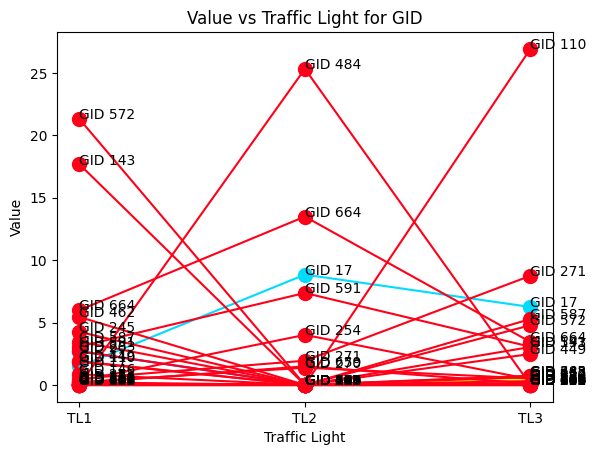

In [29]:
# group the data by "GID"
gid_groups = All_Common.groupby("GID")

# create a color map for each unique "GID" value
color_map = plt.cm.get_cmap("hsv", len(All_Common["GID"].unique()))

# filter out "GID" numbers that don't have at least one value above the threshold in each "Traffic_light" category
valid_gids = []
for gid, gid_All_Common in gid_groups:
    tl1_above_threshold = gid_All_Common[gid_All_Common["Traffic_light"] == "TL1"]["value"].max() >= 2
    tl2_above_threshold = gid_All_Common[gid_All_Common["Traffic_light"] == "TL2"]["value"].max() >= 2
    tl3_above_threshold = gid_All_Common[gid_All_Common["Traffic_light"] == "TL3"]["value"].max() >= 2
    if tl1_above_threshold and tl2_above_threshold and tl3_above_threshold:
        valid_gids.append(gid)

# filter the dataframe to only include the valid "GID" numbers
All_Common = All_Common[All_Common["GID"].isin(valid_gids)]

# group the filtered data by "GID"
gid_groups = All_Common.groupby("GID")

# plot lines and markers for each "GID" number separately
for gid, gid_All_Common in gid_groups:
    tl1_All_Common = gid_All_Common[gid_All_Common["Traffic_light"] == "TL1"]
    tl2_All_Common = gid_All_Common[gid_All_Common["Traffic_light"] == "TL2"]
    tl3_All_Common = gid_All_Common[gid_All_Common["Traffic_light"] == "TL3"]
    if not tl1_All_Common.empty and not tl2_All_Common.empty and not tl3_All_Common.empty:
        plt.plot(["TL1", "TL2", "TL3"], [tl1_All_Common["value"].iloc[0], tl2_All_Common["value"].iloc[0], tl3_All_Common["value"].iloc[0]], color=color_map(gid))
    plt.scatter(["TL1", "TL2", "TL3"], [tl1_All_Common["value"].iloc[0], tl2_All_Common["value"].iloc[0], tl3_All_Common["value"].iloc[0]], color=color_map(gid), marker="o", s=100)
    plt.text("TL1", tl1_All_Common["value"].iloc[0], f"GID {gid}")
    plt.text("TL2", tl2_All_Common["value"].iloc[0], f"GID {gid}")
    plt.text("TL3", tl3_All_Common["value"].iloc[0], f"GID {gid}")
# add axis labels and title
plt.xlabel("Traffic Light")
plt.ylabel("Value")
plt.title("Value vs Traffic Light for GID")

# set y-axis limits to 0 and 10
#plt.ylim([0, 10])

plt.show()

110, 271, 17, 659?, 270?

In [30]:
  # Save the merged DataFrame to a CSV file
  Influencers_1.to_csv('data/Influencers_TL1.csv', index=False)
  Influencers_2.to_csv('data/Influencers_TL2.csv', index=False)
  Influencers_3.to_csv('data/Influencers_TL3.csv', index=False)

In [31]:
Influencers_1.head()

,Kingdom,Phylum,Class,Order,Familia,Genera,GID,site_2,site_3,site_4,site_5,site_17,site_18,site_21,site_24,site_26,site_28,site_35,site_57,site_58,site_59,site_60,site_69,site_70,Influence
0,Bacteria,Proteobacteria,Betaproteobacteria,Burkholderiales,Comamonadaceae,Acidovorax,17,1.4798,3.7196,3.1293,1.8903,0.2118,3.0578,0.4113,1.9567,0.0040,1.7764,0.0434,1.4495,2.7858,1.8884,0.1014,1.36,1.16,17
1,Bacteria,Proteobacteria,Betaproteobacteria,Rhodocyclales,Rhodocyclaceae,Azospira,110,1.8592,3.0935,2.5740,2.7094,0.3176,2.2524,36.4445,1.0379,0.0488,0.4852,0.0724,6.4302,0.6532,0.5921,1.5623,1.47,1.72,17
2,Bacteria,Proteobacteria,Gammaproteobacteria,Pseudomonadales,Pseudomonadaceae,Pseudomonas,587,3.4718,2.0624,1.4633,2.4075,2.2763,13.7662,0.1266,0.2135,0.0013,1.5377,0.0145,1.0948,1.4025,1.4995,0.2491,0.00,0.46,16
3,Bacteria,Proteobacteria,Alphaproteobacteria,Sphingomonadales,Sphingomonadaceae,Novosphingobium,491,0.0759,0.2210,0.0397,0.0939,0.8470,0.3649,0.8068,0.1192,0.9870,1.1934,2.9525,1.4958,3.3622,2.2562,1.4698,0.00,3.20,16
4,Bacteria,Firmicutes,Clostridia,Clostridiales,Peptococcaceae,Desulfotomaculum,270,0.2277,1.9642,0.3173,0.3626,22.2340,1.5729,0.3022,13.0562,0.0026,3.7133,0.0000,0.5089,3.4966,3.7662,1.1851,0.00,1.55,15
